## Vehicle Detection

### Import 

Import of the used packages.

In [2]:
import numpy as np
import os
import cv2
import pickle
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
import Augmentor
%matplotlib inline

### Load training data

The following code load the raw data of car and none car images that are stored in folder as .PNG images. It prints their lenght and the ratio of car to none car image. Ratio is near to 100% meaning their approximatively have the same size which is valuable for training the classifier. I have added the possibility to increase the dataset using Augmentor pipeline. 

However, the accuracy of the classifier din't imprve much meaning it tends to overfit. 

In [4]:
augment_dataCar = False
if augment_dataCar is True : 
    p = Augmentor.Pipeline('train_data/vehicles/KITTI_extracted',save_format='PNG')
    p.rotate(probability=0.8, max_left_rotation=2, max_right_rotation=2)
    p.zoom(probability=0.8, min_factor=1.1, max_factor=1.4)
    p.flip_left_right(probability=0.5)
    p.random_distortion(probability=0.6, magnitude = 1, grid_width = 8, grid_height = 8)
    p.sample(8000)
    p.process()

augment_dataNonCar = False
if augment_dataNonCar is True : 
    p = Augmentor.Pipeline('train_data/non-vehicles')
    p.rotate(probability=0.8, max_left_rotation=2, max_right_rotation=2)
    p.zoom(probability=0.8, min_factor=1, max_factor=1.2)
    p.flip_left_right(probability=0.5)
    p.random_distortion(probability=0.6, magnitude = 1, grid_width = 8, grid_height = 8)
    p.sample(5000)
    p.process()

In [5]:
def renamedir() : 
    dirname = "train_data/vehicles/KITTI_extracted/output"
    for i, filename in enumerate(os.listdir(dirname)):
        os.rename(dirname + "/" + filename, dirname +"/"+ str(i) + ".png")
if (augment_dataCar and augment_dataNonCar) : 
    renamedir()

In [9]:
car_images = glob.glob('train_data/vehicles/KITTI_extracted/output/*.png')
noncar_images = glob.glob('train_data/non-vehicles/output/**/*.png')
ratio = (len(car_images)/ len(noncar_images))*100
print(len(car_images), len(noncar_images), round(ratio))

13966 13968 100


In [3]:
def show_image_compare(image1,image2) : 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    #f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title('Dataset car image', fontsize=20)
    ax2.imshow(image2)
    ax2.set_title('Data noncar image', fontsize=20)
rand = np.random.randint(0,len(car_images))
show_image(mpimg.imread(car_images[rand]), mpimg.imread(noncar_images[rand]))

NameError: name 'car_images' is not defined

In [ ]:
def show_image_compare_feature_extraction(image1,image2,image3,original,colorspace) : 
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 8))
    #f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title('channel1', fontsize=20)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title('channel2', fontsize=20)
    ax3.imshow(image3, cmap='gray')
    ax3.set_title('channel3', fontsize=20)
    ax4.imshow(original, cmap='gray')
    ax4.set_title('original', fontsize=20)
    ax1.set_xlabel(colorspace)

### Convert image to Histogram of Oriented Gradient (HOG)

HOG stands for histogram of oriented gradiant. A build in function in provided within the sklearn library. The following parameters of the hog function are listed below. 
* <b>img </b>: input image 
* <b>orient </b>: number of possible orientation of the gradient
* <b>pix_per_cell </b>: size (in pixel) of a cell
* <b>cell_per_block </b>: Number of cells in each block
* <b>vis </b>: Allow returning an image of the gradient
* <b>feature_vec </b>: Allow returning the data as a feature vector

The ``get_hog_features`` returns the extracted features and/or an example image within a ``numpy.ndarray`` depending on the value of the ``vis`` (``True`` or ``False``) parameter. 

<i>The code is copy-paste from the lession material.</i> 

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Method to Extract HOG Features from an Array of Car and Non-Car Images

The ``extract_features`` function extracts features from a list of image and returns them into a ``list``. 

<u>Note</u>: This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract flattened spatial color features and color histogram features and combine them all to be used together for classification. 

[Jeremy Shannon](https://github.com/jeremy-shannon/CarND-Vehicle-Detection/blob/master/vehicle_detection_project.ipynb) has provided in his GitHub an insightful study of the influence of the parameters of the ``get_hog_features`` function. He has chosen YUV color space,	11 orientations,	16 Pixels Per Cell,	2 Cells Per Block, and to use ALL of the color channel. It provided him a 98,17% accuracy and 55,22 s extracting time for the entire dataset. Its comparison can be found in his GitHub. 

As concluded by this [document](https://www.researchgate.net/publication/224200365_Color_exploitation_in_hog-based_traffic_sign_detection) (which analyzed the affect of color spaces for traffic sign classifiction), YCrCb and CIELab color spaces perform well. YUV shares similitudes with YCrCb ([Tushar Chugh](https://github.com/TusharChugh/Vehicle-Detection-HOG/blob/master/src/vehicle-detection.ipynb)) making YUV a good candidate as shown by different medium articles. 

From [Tushar Chugh](https://github.com/TusharChugh/Vehicle-Detection-HOG/blob/master/src/vehicle-detection.ipynb) I concluded that color histogram and spatial histogram does not provide strong accuracy improvement and reduce the extracting time. Thus, they little improvement is not a strong asset in this case. 

In the case of extraction feature for autonomous driving the accuracy is as important as the extraction time. Hence, the choice of Jeremy Shanon was logic, but I think it might be interesting to investigate another parameter set which provide great extracting time and great accuracy even if they are not the best. Jeremy Shannon didn't apply data-set enhancement which could provide an accuracy improvement. The used parameter set bring a 1,52% accuracy decrease and 13,19 s improvement meaning the data enhancement should compensate the accuracy drop to be efficient (this assumption revealed to be not true due to overfitting). 

After some experimentation, the LAB colorspace doesn't work as well as YUV or YCrCb, hence I continued with YUV. The orientation effect the calculation, I have found 12 possible gradient orientation is great deal. 

<i>The code is copy-paste from the lession material. Color Histogram and Spatial Binning have been omitted.</i>

In [5]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = np.copy(np.sqrt(np.mean(np.square(image))))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Preparing the data

In [10]:
# Feature extraction parameters
colorspace = 'YUV'
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

In [11]:
# Extracting feature from car and noncar images
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

16.86 s of extraction time per image (ALL channel)


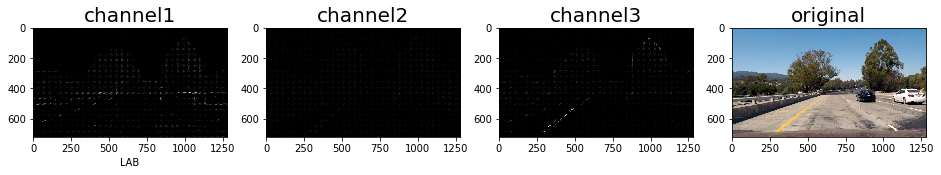

In [67]:
img = mpimg.imread('./test_images/1.bmp')
img2 = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
t=time.time()
temp, im1 = get_hog_features(img2[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
temp, im2 = get_hog_features(img2[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
temp, im3 = get_hog_features(img2[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
t2 = time.time()
show_image_compare_feature_extraction(im1,im2,im3,img,'LAB')
print(round(t2-t,2), 's of extraction time per image (ALL channel)')

In the code below, the ```car_feature``` and ```notcar_feature``` are combined vertically. The created vetor is then scaled using ```StandardSacler``` (it removes the mean and provide a unit variance of the dataset). The result vector is created and  combined horizontally to feature vector. The test and validation are then created randomly with 20% proportion and shuffle as well. 

In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
#print(X[0])
#StandardScaler decrease classifying performances (?)
    # Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
pickle.dump(X_scaler, open('X_scaler', 'wb'))
    # Apply the scaler to X
scaled_X = X_scaler.transform(X)
pickle.dump(X_scaler, open('scaled_X', 'wb'))
#print(scaled_X[0])
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split X and y (data) into training and testing set
#rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

### Train a classifier

The SGDC classifier used is variant of a linear support vector machine model. I have tested Naive Bayes and decision three model, which have shown to have similar accurcy result. The special SGDC classifier provides however an improved training time for a some accuracy, therefore I prefered using this insteaf of the other. 

In [14]:
# Use a linear SVC 
SGDC = linear_model.SGDClassifier()
# Check the training time for the SVC
t = time.time()
SGDC.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(SGDC.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SGDC predicts: ', SGDC.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the model to disk
filename = 'model'+str(colorspace)+str(orient)+str(pix_per_cell)+str(cell_per_block)+str(hog_channel)+'.sav'
pickle.dump(SGDC, open(filename, 'wb'))

1.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9835
My SGDC predicts:  [ 0.  1.  1.  0.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  0.  1.  1.]
0.01099 Seconds to predict 10 labels with SVC


In [7]:
# load the model from disk
filename = 'model'+str(colorspace)+str(orient)+str(pix_per_cell)+str(cell_per_block)+hog_channel+'.sav'
SGDC = pickle.load(open(filename, 'rb'))

X_scaler = pickle.load(open('X_scaler', 'rb'))
scaled_X = pickle.load(open('scaled_X', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'modelYUV1282ALL.sav'

### Sliding Windows

```Find_car``` is a function which extracts hog features of an entire image than apply a sliding windows technic to this HOG image. Each frame taken appart from the sliding windows is analyzed by the SDGC classifier to predict whether the frame is a vehicle or not. If the frame reveals to be a car, the the boxes coordinates of the predicted vehicle are calculated and returned by the the function. An image with the boxen vehicle is also returned. 

The function ```apply_sliding_window``` is in charge to apply the ```Find_car``` sliding window method using multiple window sizes which allow the procedure to be scale proof. The y start and stop position are use a band where the sliding window technic is applied. It allows to focus on a ROI. The scaled of the sliding window is find in order to fit a entire car in the frame. 

I am facing a computation time problem : computing the sliding window technic takes 15s per images, involving a tremedous amount of time to calute an entire video. This problem should be solved, but I don't find any problem. 

Even if the classifier provides a great accuracy, the amount of false positive and negative is still high. Increasing the the ROI and adding sliding window search wasn't viable due to the really high time of computation. The color histogram might avoid those false positive, therefore this possibility should be tested. 

<i>The code is inspired from the lession material.</i>

In [18]:
# conver the given image into the chosen color channel
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Here is your draw_boxes function from the previous exercise (from lecture)
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [15]:
def find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]  # sub-sampling
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
   
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_stacked = np.hstack(hog_features).reshape(1, -1)
            test_features = X_scaler.transform(test_stacked)    
            #test_features = scaler.transform(np.array(features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = SGDC.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))

    return draw_img, bboxes

In [16]:
def apply_sliding_window(image, SGDC, X_scaler, orient, pix_per_cell, cell_per_block): 
    t = time.time()
    #rectangles = []
    bboxes = []
    ystart = 400
    ystop = 500 
    out_img, bboxes1 = find_cars(image, ystart, ystop, 1.0, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 400
    ystop = 500 
    out_img, bboxes2 = find_cars(image, ystart, ystop, 1.3, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 410
    ystop = 500 
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, 1.4, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 420
    ystop = 556 
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, 1.6, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 430
    ystop = 556 
    out_img, bboxes5 = find_cars (out_img, ystart, ystop, 1.8, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 430
    ystop = 556 
    out_img, bboxes6 = find_cars (out_img, ystart, ystop, 2.0, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 440
    ystop = 556 
    out_img, bboxes7 = find_cars (out_img, ystart, ystop, 1.9, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 400
    ystop = 556 
    out_img, bboxes8 = find_cars (out_img, ystart, ystop, 1.3, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 400
    ystop = 556 
    out_img, bboxes9 = find_cars (out_img, ystart, ystop, 2.2, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    ystart = 500 
    ystop = 656 
    out_img, bboxes10 = find_cars (out_img, ystart, ystop, 3.0, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    bboxes.extend(bboxes10)
    
    t2 = time.time()
    print(round(t2-t,2), 'apply sliding window')
    return out_img, bboxes

In [61]:
img = mpimg.imread('./test_images/3.bmp')
ystart = 400
ystop = 596
scale = 1.2
#plt.imshow(out_img)
t=time.time()
out, bo = apply_sliding_window(img, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
t2 = time.time()
print(round(t2-t,2), 's of execution per frame')

14.81 apply sliding window
14.81 s of execution per frame


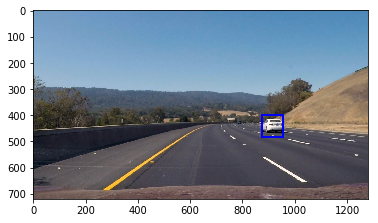

In [62]:
temp=draw_boxes(img,bo)
plt.imshow(temp)

### Heatmap

To avoid false postive, a heat map is used. The principle is the following, first a map is create, zero array-like of the analyzed image size. Once, a car is detected and box is found, the boxen area of image is added by 1 on the same region of the array. Therefore, when a zero on the heat means that no car has ever been found in the process. When its values is one, a vehicle have been found once and when the value is greater than one, a vehcile have been multiple times. The heatmap thus a measure of certainty of the prediction. Applying a treshold of 1, meaning we consider that the confidence of unique positive prediction is this area is not enough, allow one to filter the false positves. 

In [54]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

0 cars found


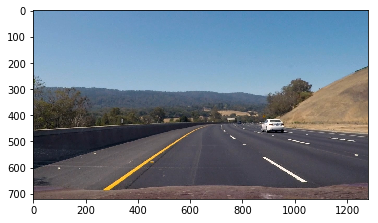

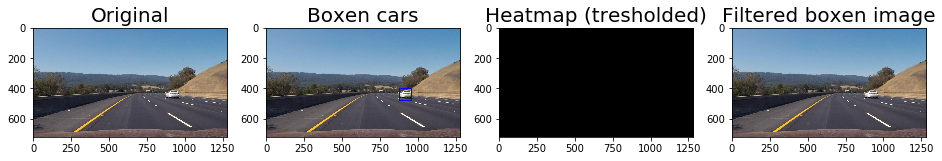

In [63]:
heatmap = np.zeros_like(out[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bo)
heatmap = apply_threshold(heatmap, 1)
labels = label(heatmap)

print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

# Read in the last image above
#image = mpimg.imread('img105.jpg')
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.imshow(draw_img)

show_image_compare_heatmap(img,heatmap,temp,draw_img)

In [56]:
def show_image_compare_heatmap(img,heatmap,temp,boxen) : 
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 8))
    #f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original', fontsize=20)
    ax2.imshow(temp, cmap='gray')
    ax2.set_title('Boxen cars', fontsize=20)
    ax3.imshow(heatmap, cmap='gray')
    ax3.set_title('Heatmap (tresholded)', fontsize=20)
    ax4.imshow(boxen, cmap='gray')
    ax4.set_title('Filtered boxen image', fontsize=20)

###  Vheicle detection pipeline

14.46 apply sliding window


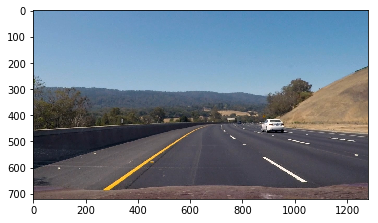

In [136]:
def vehicle_detection_piepline(image) : 
    # Find cars in image using multiple sliding window method 
    # Filter false positive using tresholded heatmap
    # label the vehicles
    # draw the boxes on the image
    detected_image, boxes = apply_sliding_window(image, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    heatmap = np.zeros_like(detected_image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,boxes)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
    
image_output_vehicle = vehicle_detection_piepline(mpimg.imread('./test_images/3.bmp'))
plt.imshow(image_output_vehicle)

In [137]:
from collections import deque
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(vehicle_detection_piepline)
%time video_clip.write_videofile(output, audio=False)

14.33 apply sliding window
[MoviePy] >>>> Building video test_result.mp4
[MoviePy] Writing video test_result.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

13.96 apply sliding window


  3%|██▏                                                                                | 1/39 [00:13<08:51, 14.00s/it]

14.39 apply sliding window


  5%|████▎                                                                              | 2/39 [00:28<08:42, 14.12s/it]

14.36 apply sliding window


  8%|██████▍                                                                            | 3/39 [00:42<08:31, 14.21s/it]

14.56 apply sliding window


 10%|████████▌                                                                          | 4/39 [00:57<08:21, 14.32s/it]

14.52 apply sliding window


 13%|██████████▋                                                                        | 5/39 [01:11<08:09, 14.39s/it]

14.43 apply sliding window


 15%|████████████▊                                                                      | 6/39 [01:26<07:55, 14.41s/it]

14.45 apply sliding window


 18%|██████████████▉                                                                    | 7/39 [01:40<07:42, 14.44s/it]

14.12 apply sliding window


 21%|█████████████████                                                                  | 8/39 [01:55<07:24, 14.35s/it]

14.3 apply sliding window


 23%|███████████████████▏                                                               | 9/39 [02:09<07:10, 14.35s/it]

14.42 apply sliding window


 26%|█████████████████████                                                             | 10/39 [02:23<06:57, 14.38s/it]

14.35 apply sliding window


 28%|███████████████████████▏                                                          | 11/39 [02:38<06:42, 14.38s/it]

14.35 apply sliding window


 31%|█████████████████████████▏                                                        | 12/39 [02:52<06:28, 14.38s/it]

14.43 apply sliding window


 33%|███████████████████████████▎                                                      | 13/39 [03:07<06:14, 14.41s/it]

15.1 apply sliding window


 36%|█████████████████████████████▍                                                    | 14/39 [03:22<06:05, 14.63s/it]

14.43 apply sliding window


 38%|███████████████████████████████▌                                                  | 15/39 [03:36<05:50, 14.58s/it]

14.19 apply sliding window


 41%|█████████████████████████████████▋                                                | 16/39 [03:50<05:32, 14.47s/it]

14.42 apply sliding window


 44%|███████████████████████████████████▋                                              | 17/39 [04:05<05:18, 14.47s/it]

14.28 apply sliding window


 46%|█████████████████████████████████████▊                                            | 18/39 [04:19<05:02, 14.43s/it]

13.83 apply sliding window


 49%|███████████████████████████████████████▉                                          | 19/39 [04:33<04:45, 14.26s/it]

14.29 apply sliding window


 51%|██████████████████████████████████████████                                        | 20/39 [04:47<04:31, 14.28s/it]

14.57 apply sliding window


 54%|████████████████████████████████████████████▏                                     | 21/39 [05:02<04:18, 14.37s/it]

14.05 apply sliding window


 56%|██████████████████████████████████████████████▎                                   | 22/39 [05:16<04:02, 14.29s/it]

14.36 apply sliding window


 59%|████████████████████████████████████████████████▎                                 | 23/39 [05:31<03:49, 14.32s/it]

14.55 apply sliding window


 62%|██████████████████████████████████████████████████▍                               | 24/39 [05:45<03:36, 14.40s/it]

14.2 apply sliding window


 64%|████████████████████████████████████████████████████▌                             | 25/39 [05:59<03:20, 14.35s/it]

14.05 apply sliding window


 67%|██████████████████████████████████████████████████████▋                           | 26/39 [06:13<03:05, 14.27s/it]

14.21 apply sliding window


 69%|████████████████████████████████████████████████████████▊                         | 27/39 [06:28<02:51, 14.27s/it]

14.31 apply sliding window


 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [06:42<02:37, 14.29s/it]

14.3 apply sliding window


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [06:56<02:23, 14.30s/it]

14.33 apply sliding window


 77%|███████████████████████████████████████████████████████████████                   | 30/39 [07:11<02:08, 14.32s/it]

14.52 apply sliding window


 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [07:25<01:55, 14.39s/it]

14.46 apply sliding window


 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [07:40<01:40, 14.42s/it]

14.3 apply sliding window


 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [07:54<01:26, 14.40s/it]

14.79 apply sliding window


 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [08:09<01:12, 14.53s/it]

14.27 apply sliding window


 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [08:23<00:57, 14.46s/it]

14.38 apply sliding window


 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [08:38<00:43, 14.45s/it]

14.35 apply sliding window


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [08:52<00:28, 14.43s/it]

14.34 apply sliding window


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [09:06<00:14, 14.41s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_result.mp4 

Wall time: 9min 7s


In [24]:
history = deque(maxlen = 8)
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(vehicle_detection_piepline)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [6:37:07<00:15, 15.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 6h 37min 8s


The output video can be found [here](https://youtu.be/Gt2ZO6IfRfo)

### temp 

In [ ]:
def apply_sliding_window(img, SGDC, X_scaler, orient, pix_per_cell, cell_per_block): 
    t = time.time()
    rectangles = []
    ystart = 400
    ystop = 464
    scale = 1.0
    boxen_image, bbobx = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx)
    
    ystart = 400
    ystop = 464
    scale = 1.3
    boxen_image, bbobx8 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx8)
    
    ystart = 416
    ystop = 480
    scale = 1.0
    boxen_image, bbobx1 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx)
    
    ystart = 400
    ystop = 496
    scale = 1.5
    boxen_image, bbobx2 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx2)

    ystart = 432
    ystop = 528
    scale = 1.5
    boxen_image, bbobx3 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx3)
    
    ystart = 400
    ystop = 528
    scale = 2.0
    boxen_image, bbobx4 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx4)
    
    ystart = 432
    ystop = 560
    scale = 2.0
    boxen_image, bbobx5 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx5)
    
    ystart = 400
    ystop = 596
    scale = 1.2
    boxen_image, bbobx6 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx6)
    
    ystart = 464
    ystop = 660
    scale = 3.5
    boxen_image, bbobx7 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx7)
    
    ystart = 400
    ystop = 556
    scale = 1.3
    #boxen_image, bbobx9 = find_cars (img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    #rectangles.extend(bbobx9)
    
    ystart = 400
    ystop = 556
    scale = 2.2 
    #boxen_image, bbobx10 = find_cars (img, ystart, ystop, sacle, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    #rectangles.extend(bbobx10)
    t2 = time.time()
    print(round(t2-t,2), 'apply sliding window')
    return boxen_image, rectangles

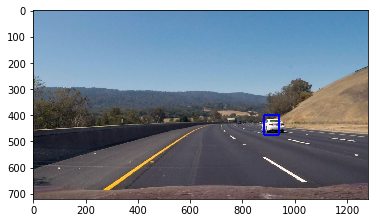

In [23]:
def vehicle_detection_piepline(image) : 
    # Find cars in image using sliding window 
    # Filter false positive using tresholded heatmap
    # label the vehicles
    rectangles = []
    ystart = 400
    ystop = 464
    scale = 1.0
    boxen_image, bbobx = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx)
    
    ystart = 400
    ystop = 464
    scale = 1.3
    boxen_image, bbobx8 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx8)
    
    ystart = 416
    ystop = 480
    scale = 1.0
    boxen_image, bbobx1 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx)
    
    ystart = 400
    ystop = 496
    scale = 1.5
    boxen_image, bbobx2 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx2)

    ystart = 432
    ystop = 528
    scale = 1.5
    boxen_image, bbobx3 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx3)
    
    ystart = 400
    ystop = 528
    scale = 2.0
    boxen_image, bbobx4 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx4)
    
    ystart = 432
    ystop = 560
    scale = 2.0
    boxen_image, bbobx5 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx5)
    
    ystart = 400
    ystop = 596
    scale = 1.2
    boxen_image, bbobx6 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx6)
    
    ystart = 464
    ystop = 660
    scale = 3.5
    boxen_image, bbobx7 = find_cars(img, ystart, ystop, scale, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx7)
    
    ystart = 400
    ystop = 556
    boxen_image, bbobx9 = find_cars (img, ystart, ystop, 1.3, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx9)
    
    ystart = 400
    ystop = 556
    boxen_image, bbobx10 = find_cars (img, ystart, ystop, 2.2, SGDC, X_scaler, orient, pix_per_cell, cell_per_block)
    rectangles.extend(bbobx10)
    
    heatmap = np.zeros_like(boxen_image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,rectangles)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img
    
image_output_vehicle = vehicle_detection_piepline(mpimg.imread('./test_images/3.bmp'))
plt.imshow(image_output_vehicle)